In [2]:
%matplotlib inline

In [3]:
import numpy as np                   # advanced math library
import matplotlib.pyplot as plt      # MATLAB like plotting routines
import random                        # for generating random numbers

from keras.datasets import mnist     # MNIST dataset is included in Keras%
from keras.models import Sequential  # Model type to be used

from keras.layers.core import Dense, Dropout, Activation # Types of layers to be used in our model
from keras.utils import np_utils                         # NumPy related tools
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Flatten
from keras.layers.normalization import BatchNormalization

from keras import optimizers


from sklearn.metrics import confusion_matrix
import itertools

Training matrix shape (60000, 28, 28, 1)
Testing matrix shape (10000, 28, 28, 1)


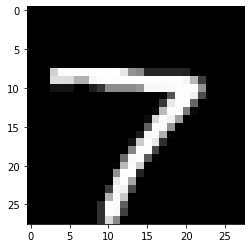

In [4]:
# Reload the MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Again, do some formatting
# Except we do not flatten each image into a 784-length vector because we want to perform convolutions first

X_train = X_train.reshape(60000, 28, 28, 1) #add an additional dimension to represent the single-channel
X_test = X_test.reshape(10000, 28, 28, 1)

X_train = X_train.astype('float32')         # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                              # normalize each value for each pixel for the entire vector for each input
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)
plt.imshow(X_train[1332,:,:,0], cmap = 'gray')

In [5]:
nb_classes = 10 # number of unique digits

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08, validation_split=0.2)

test_gen = ImageDataGenerator()

train_generator = gen.flow(X_train, Y_train, batch_size=128, subset='training')
valid_generator = gen.flow(X_train, Y_train, batch_size=128, subset='validation')
test_generator = test_gen.flow(X_test, Y_test, batch_size=128)


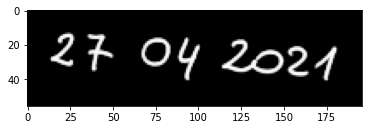

In [6]:
from keras.preprocessing.image import load_img, img_to_array

img = load_img('test.png', color_mode = "grayscale")
img = img_to_array(img).astype(np.float32)
print(img.shape)
plt.imshow(img[:,:,0], cmap = 'gray')
img = np.expand_dims(img, 0)
print(img.shape)

In [ ]:
modelfc = Sequential()                                 # Linear stacking of layers

# Convolution Layer 1
modelfc.add(Conv2D(16, (5, 5), input_shape=(None,None,1))) # 16 different 5x5 kernels -- so 16 feature maps
modelfc.add(Activation('relu') )                       # activation
modelfc.add(MaxPooling2D(pool_size=(2,2)))             # Pool the max values over a 2x2 kernel

# Convolution Layer 2
modelfc.add(Conv2D(32, (5, 5)))                        # 32 different 5x5 kernels -- so 32 feature maps
modelfc.add(Activation('relu'))                        # activation
modelfc.add(MaxPooling2D(pool_size=(2,2)))             # Pool the max values over a 2x2 kernel


modelfc.add(Conv2D(128, (4, 4)))                        
modelfc.add(Activation('relu'))                        # activation

modelfc.add(Conv2D(10, (1, 1)))                              
modelfc.add(Activation('softmax'))                     # softmax activation

modelfc.summary()

In [ ]:
# we'll use the same optimizer
adam = optimizers.Adam(lr=0.001)
modelfc.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

Y_train_fc = np.reshape(Y_train, (60000, 1, 1, 10))
Y_test_fc = np.reshape(Y_test, (10000, 1, 1, 10))
print(Y_test_fc.shape)

gen_fc = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08, validation_split=0.2)

test_gen_fc = ImageDataGenerator()

train_generator_fc = gen_fc.flow(X_train, Y_train_fc, batch_size=120, subset='training')
valid_generator_fc = gen_fc.flow(X_train, Y_train_fc, batch_size=120, subset='validation')
test_generator_fc = test_gen_fc.flow(X_test, Y_test_fc, batch_size=128)

modelfc.fit_generator(train_generator_fc, steps_per_epoch=50000//128, epochs=5, verbose=1, validation_data=valid_generator_fc, validation_steps = 10000 // 128)

In [ ]:
score = modelfc.evaluate(X_test, Y_test_fc)
print('Test score:', score[0])
print('Test accuracy:', score[1])

In [ ]:
# Predykcje dla obrazu dowolnej wielkości
preds = modelfc.predict(img)
print(preds.shape)
plt.imshow(preds[0, :, :, 0])

In [ ]:
x_axis = np.linspace(-1, 1, 28)[:, None]
y_axis = np.linspace(-1, 1, 28)[None, :]

arr = 1 - np.sqrt(x_axis ** 2 + y_axis ** 2)
arr[arr<0] = 0
plt.imshow(arr)

def draw_heatmap(image, preds, kernel, step = 4):
  import cv2

  rows = preds.shape[0]
  cols = preds.shape[1]
  sy = kernel.shape[0]
  sx = kernel.shape[1]

  hmap = np.zeros(image.shape[0:2])

  for r in range(rows):
    for c in range(cols):
      y = r * step
      x = c * step

      hmap[y:y+sy, x:x+sx] = hmap[y:y+sy, x:x+sx] + preds[r, c] * kernel

  if np.amax(hmap) > 1:
    hmap = hmap / np.amax(hmap)
  hmap2 = (hmap * 255).astype(np.uint8)

  cmap = cv2.applyColorMap(hmap2, cv2.COLORMAP_HOT)
  cmap = cmap[:,:,::-1]
  img = (image * 255).astype(np.uint8)
  ret = 0.3 * img + 0.7 * cmap

  return ret.astype(np.uint8)

In [ ]:
for i in range(10):
  plt.imshow(draw_heatmap(img[0], preds[0, :, :, i], arr))
  plt.figure()

In [ ]:
def to_fully_conv(model):
    from keras.engine import InputLayer

    new_model = Sequential()

    input_layer = InputLayer(input_shape=(None, None, 1), name="input_new")

    new_model.add(input_layer)

    for layer in model.layers:
        
        if "Flatten" in str(layer):

            flattened_ipt = True
            f_dim = layer.input_shape

        elif "Dense" in str(layer):
            input_shape = layer.input_shape
            output_dim =  layer.get_weights()[1].shape[0]
            W,b = layer.get_weights()
            if flattened_ipt:
                shape = (f_dim[1],f_dim[2],f_dim[3],output_dim)
                new_W = W.reshape(shape)
                new_layer = Conv2D(output_dim,
                                          (f_dim[1],f_dim[2]),
                                          strides=(1,1),
                                          activation=layer.activation,
                                          padding='valid',
                                          weights=[new_W,b])
                
                new_model.add(new_layer)
                flattened_ipt = False

            else:
                shape = (1,1,input_shape[1],output_dim)
                new_W = W.reshape(shape)
                new_layer = Conv2D(output_dim,
                                          (1,1),
                                          strides=(1,1),
                                          activation=layer.activation,
                                          padding='valid',
                                          weights=[new_W,b])
                
                new_model.add(new_layer)

        else:
            new_model.add(layer)


    return new_model

In [ ]:
new_model = to_fully_conv(modelfc)
new_model.summary()

In [ ]:
pred2 = new_model.predict(img)
print(pred2.shape)
plt.imshow(pred2[0,:,:,2])
np.amax(pred2[0,:,:,2])

In [ ]:
for i in range(10):
  plt.imshow(draw_heatmap(img[0], pred2[0, :, :, i], arr))
  plt.figure()

In [ ]:
# Wykorzystanie wag wytrenowanej sieci "klasycznej"
cnt = X_train.shape[0]
neg_cnt = 5000
X_neg = np.zeros((neg_cnt, 28, 28, 1))
y_neg = np.ones((neg_cnt)) * 10
print(X_neg.shape)

theta = np.radians(45)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c, -s), (s, c)))

for i in range(neg_cnt):
  i1 = X_train[random.randint(0, cnt-1)]
  i2 = X_train[random.randint(0, cnt-1)]
  i3 = X_train[random.randint(0, cnt-1)]
  i4 = X_train[random.randint(0, cnt-1)]
  tmp = np.vstack((np.hstack((i1, i2)), np.hstack((i3, i4))))
  tmp = np.pad(tmp[:,:,0], pad_width=14, mode='constant')

  c = np.random.randint(-14, 14, 2)
  c = (np.matmul(c, R) + 42).astype(np.int32)
  tmp2 = tmp[(c[0]-14):(c[0]+14),(c[1]-14):(c[1]+14)]
  X_neg[i,:,:,0] = tmp2

X_train_bg = np.concatenate((X_train, X_neg))
y_train_bg = np.concatenate((y_train, y_neg))
Y_train_bg = np_utils.to_categorical(y_train_bg, nb_classes + 1)
Y_train_bg = np.reshape(Y_train_bg, (Y_train_bg.shape[0], 1, 1, 11))
print(X_train_bg.shape)
print(Y_train_bg.shape)

In [ ]:
plt.imshow(X_neg[30,:,:,0])

In [ ]:
gen_bg = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08, validation_split=0.2)

train_generator_bg = gen_bg.flow(X_train_bg, Y_train_bg, batch_size=128, subset='training')
valid_generator_bg = gen_bg.flow(X_train_bg, Y_train_bg, batch_size=128, subset='validation')


modelbg = Sequential()                                 # Linear stacking of layers

# Convolution Layer 1
modelbg.add(Conv2D(16, (5, 5), input_shape=(None,None,1))) # 16 different 5x5 kernels -- so 16 feature maps
modelbg.add(Activation('relu') )                       # activation
modelbg.add(MaxPooling2D(pool_size=(2,2)))             # Pool the max values over a 2x2 kernel

# Convolution Layer 2
modelbg.add(Conv2D(32, (5, 5)))                        # 32 different 5x5 kernels -- so 32 feature maps
modelbg.add(Activation('relu'))                        # activation
modelbg.add(MaxPooling2D(pool_size=(2,2)))             # Pool the max values over a 2x2 kernel


modelbg.add(Conv2D(128, (4, 4)))                        
modelbg.add(Activation('relu'))                        # activation

modelbg.add(Conv2D(10+1, (1, 1)))                              
modelbg.add(Activation('softmax'))                     # softmax activation

modelbg.summary()

In [ ]:
adam = optimizers.Adam(lr=0.001)
modelbg.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
modelbg.fit_generator(train_generator_bg, steps_per_epoch=50000//128, epochs=5, verbose=1, validation_data=valid_generator_bg, validation_steps = 10000 // 128)

In [ ]:
pred3 = modelbg.predict(img)
print(pred3.shape)
plt.imshow(pred3[0,:,:,2])
np.amax(pred3[0,:,:,2])

In [ ]:
for i in range(11):
  plt.imshow(draw_heatmap(img[0], pred3[0, :, :, i], arr))
  plt.figure()

In [ ]:
import scipy.ndimage.filters as filters
import cv2

outimg = cv2.cvtColor(img[0], cv2.COLOR_GRAY2BGR)
for digit in range(10):
  p0 = pred3[0, :, :, digit].copy()
  p0[p0 < 0.997] = 0
  preds_max = filters.maximum_filter(p0, 5)
  preds_max = np.bitwise_and((p0 == preds_max), (p0 > 0))
  plt.imshow(preds_max)

  ids = np.nonzero(preds_max)
  step = 4
  sz = 28
  for (y,x) in zip(*ids):
    cv2.rectangle(outimg, (x*step,y*step), (x*step+sz, y*step+sz), (1, 0, 0))
    cv2.putText(outimg, str(digit), (x*step, y*step+sz), cv2.FONT_HERSHEY_PLAIN, 1, (1, 0, 0))

plt.imshow(outimg)